<a href="https://colab.research.google.com/github/santiagoed4/Prediction/blob/master/ROP_Prediction_Well2131.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate of penetration prediction in offshore drilling operations (Well 21-31)

In this application, the rate of penetration is predicted based on the features measured during the operation. In this case, 44 features were measured for the Well 21-31.  Random forest, support vector machine, and network neural are analyzed based on mean squared error and mean absolute error  to analyzed how well the model fit with the data. The methods were selected based on the literature review. Expecifically, the research developed by Cesar Soares, Kenneth Gray (Real time predictive capabilities of analytical and machine learning rate of penetration models)


In [0]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime
import tensorflow as tf

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.preprocessing import  StandardScaler, MinMaxScaler


# Deep learning
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential 
from keras.callbacks import History 
from keras.layers import LSTM
from keras.layers import Dense


# Train-test split
from sklearn.model_selection import train_test_split


# Hyperparameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Metrics

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

# Additionals

from pprint import pprint
from math import sqrt


Using TensorFlow backend.


In [0]:
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
from bokeh.models import HoverTool
from bokeh.models.ranges import Range1d
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool
from bokeh.models import BoxSelectTool
from bokeh.layouts import gridplot
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs, TableColumn, DataTable
from bokeh.layouts import column, row, WidgetBox
from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel

## Upload data-set 

Utah FORGE Roosevelt Hot Springs Drilling Data for Student Competition
Diagnostic drilling data (Pason log files) from Well 58-32 (previously labeled MU-ESW1), which was drilled near Milford Utah during Phase 2B of the FORGE Project to confirm geothermal reservoir characteristics met requirements for the final FORGE site. This dataset includes both raw, unprocessed drilling data recorded at 1Hz and a processed version downscaled to ~0.3m (1 ft) intervals. 
* Geothermal Data Repository (https://gdr.openei.org/submissions/1113)

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=156qrrYB2VCgOI0Wj6XgawfuXjjs4UZ1Q'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

156qrrYB2VCgOI0Wj6XgawfuXjjs4UZ1Q


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Well_21_31.csv')  
df1 = pd.read_csv('Well_21_31.csv')
# Dataset is now stored in a Pandas Dataframe
df1.head(3)

,DEPTH,ROP,WOB,CO2,CH4,H2S,TEMPIN,TEMPOUT,FRACT,MUDLOSS,QUARTZIT,CALCITE,PYRITE,HEMATITE,EPIDOTAL,CHLORITE,ANHYDRIT,SERICITE,PP,SPM1,SPM2,FLOWIN,FLOWOUT%,GAINLOSS,RPM,TORQUE,PITVOL,TUFFASH,RHYOLITE,BASALT,VOLCAN,ANDESITE,DACITE,TUFFCRYS,VOLCSEDI,CHERTARG,MARL,CLAYST%,CLAY%,SILTST%,SANDST%,SAND%,MEDSAND%,CRSSAND
0,130,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,60,0,0
1,131,498,0,206,0,0,55,55,0,0,0,0,0,0,0,0,0,0,661,99,105,668,35,0,57,0,209,0,0,0,0,0,0,0,0,0,0,0,40,0,0,60,0,0
2,132,675,0,206,0,0,56,55,0,0,0,0,0,0,0,0,0,0,676,97,105,668,32,0,57,0,204,0,0,0,0,0,0,0,0,0,0,0,40,0,0,60,0,0


## Preprocessing data
The data is filtered to work with **International Units**. Then, the data is standarized. 

In [0]:
dfnew= df1.filter(['ROP', 'DEPTH','WOB','TEMPIN','TEMPOUT','FLOWIN','FLOWOUT%','RPM','TORQUE'], axis=1)

dfnew.shape

(5979, 9)

In [0]:
dfnew.describe()

,ROP,DEPTH,WOB,TEMPIN,TEMPOUT,FLOWIN,FLOWOUT%,RPM,TORQUE
count,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000
mean,98.837933,3119.000000,10.131962,107.830406,117.193009,712.113397,42.332497,59.585215,1934.167252
std,116.417445,1726.132961,8.345709,19.431197,21.131624,95.939043,6.621601,14.922076,1365.923365
min,0.000000,130.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1624.500000,2.000000,98.000000,107.000000,662.000000,39.000000,54.000000,238.500000
50%,49.000000,3119.000000,8.000000,110.000000,120.000000,734.000000,43.000000,59.000000,2148.000000
75%,128.000000,4613.500000,18.000000,118.000000,132.000000,760.000000,46.000000,68.000000,3134.000000
max,888.000000,6108.000000,30.000000,142.000000,165.000000,799.000000,56.000000,102.000000,4850.000000


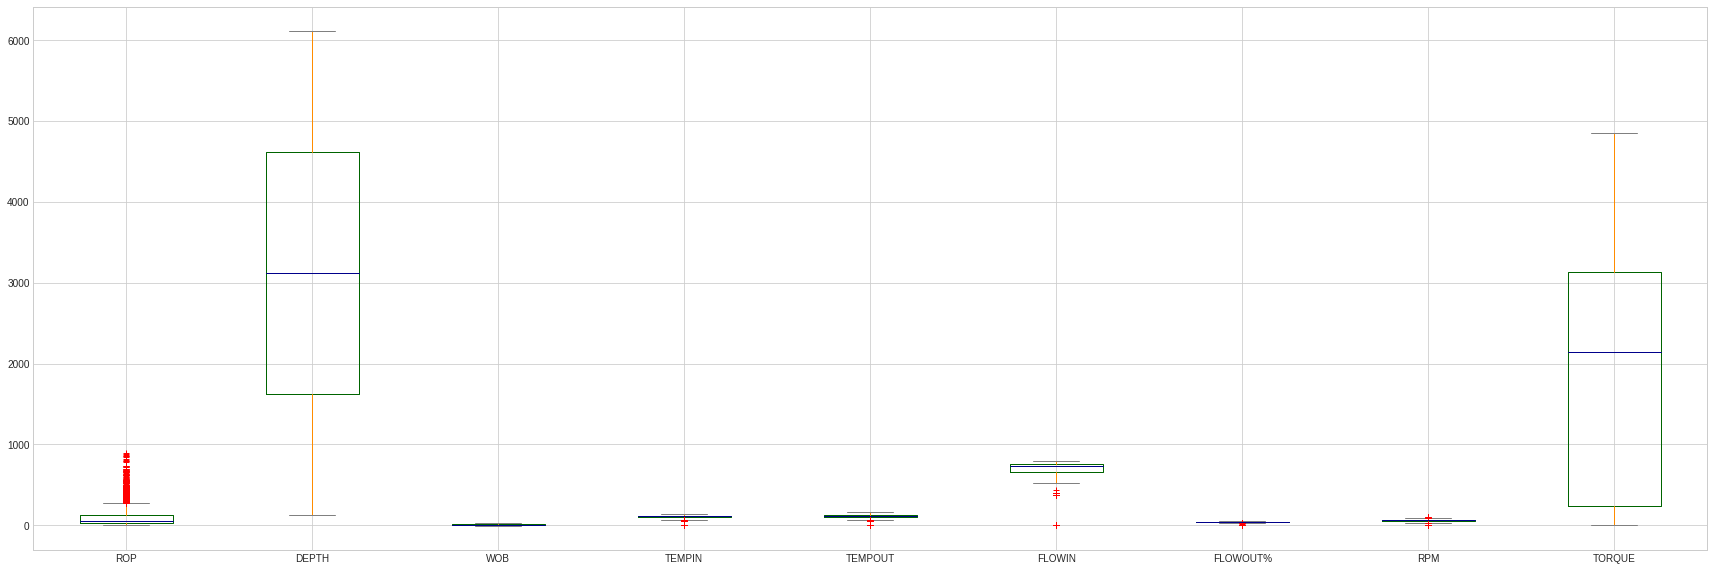

In [0]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
bp=dfnew.plot.box(color=color, sym='r+', figsize=(30,10))

Aditional preprocessing of data for LSTM method.

In [0]:
dfnew_lstm=np.array(dfnew)

In [0]:
min_max_scaler=preprocessing.StandardScaler()
np_scaled=min_max_scaler.fit_transform(dfnew_lstm)
df_scaled=pd.DataFrame(np_scaled)
print ('Sacaled shape:', df_scaled.shape)
df_scaled.head(2)

Sacaled shape: (5979, 9)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8
0,-0.849067,-1.731761,-1.094302,-5.549809,-5.546323,-7.423182,-6.393626,-3.993426,-1.416133
1,3.429000,-1.731182,-1.214134,-2.719072,-2.943371,-0.459845,-1.107453,-0.173262,-1.416133


In [0]:
numerical_cols=['ROP', 'DEPTH','WOB','TEMPIN','TEMPOUT','FLOWIN','FLOWOUT%','RPM','TORQUE']

In [0]:
scaler_all_data = MinMaxScaler()
data_scaled = scaler_all_data.fit_transform(dfnew)
df_data_scaled=pd.DataFrame(data_scaled)
df_data_scaled.columns = numerical_cols
df_data_scaled.head(5)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,ROP,DEPTH,WOB,TEMPIN,TEMPOUT,FLOWIN,FLOWOUT%,RPM,TORQUE
0,0.000000,0.000000,0.147059,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.560811,0.000167,0.117647,0.387324,0.333333,0.836045,0.625000,0.558824,0.0
2,0.760135,0.000335,0.117647,0.394366,0.333333,0.836045,0.571429,0.558824,0.0
3,0.614865,0.000502,0.147059,0.394366,0.333333,0.834793,0.589286,0.539216,0.0
4,0.500000,0.000669,0.147059,0.394366,0.333333,0.834793,0.589286,0.529412,0.0


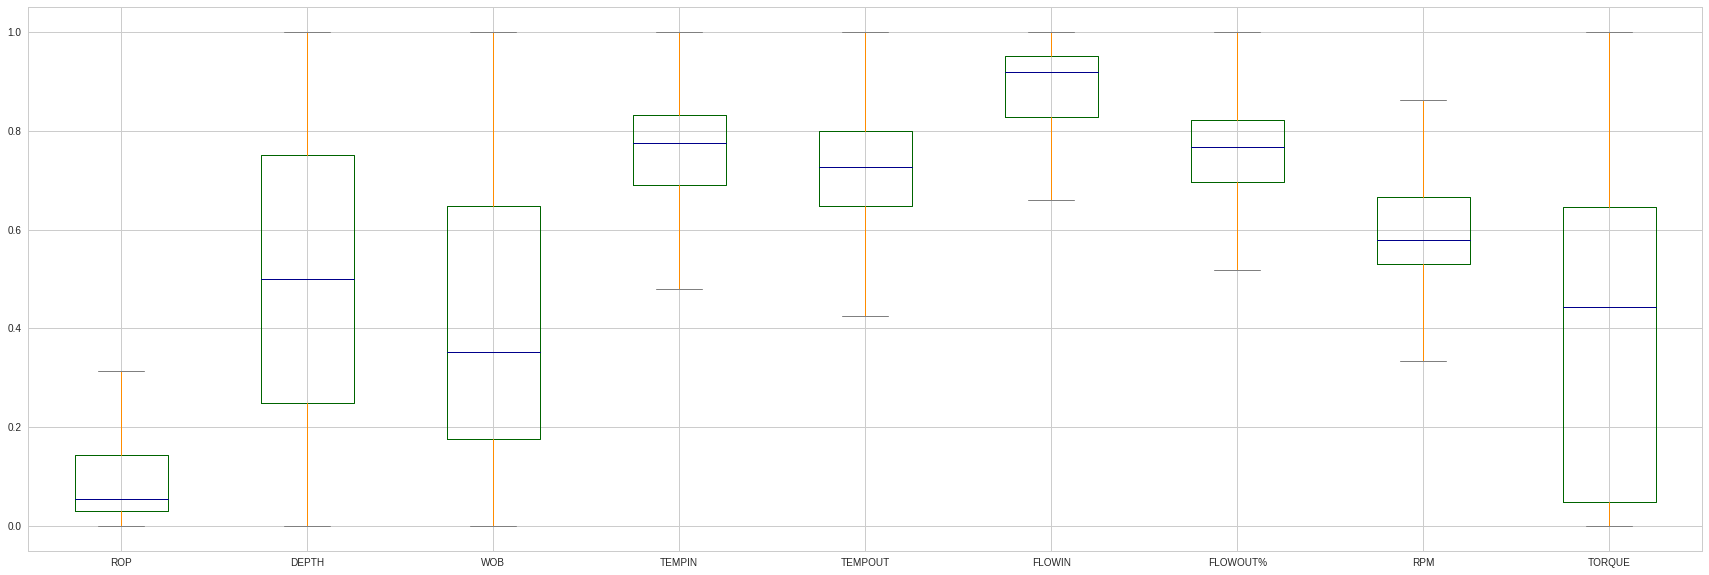

In [0]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
bp_scaled_all_data = df_data_scaled.plot.box(color=color, sym='r+' ,figsize=(30,10))

In [0]:
#@Select variable

from bokeh.models import Span
Variable = 'TEMPIN' #@param ['ROP', 'DEPTH','WOB','TEMPIN','TEMPOUT','FLOWIN','FLOWOUT%','RPM','TORQUE']
#@title
output_notebook()
variable = Variable
source = ColumnDataSource(dfnew)
color_mapper = LinearColorMapper(palette="Viridis256", low=dfnew[variable].min(), high=dfnew[variable].max())



hover = HoverTool(tooltips=[
    ('Depth', '@{DEPTH}'), 
    ('ROP', '@{ROP}'),
  	 ])
tools = [PanTool(), WheelZoomTool(), ResetTool(), hover, 'box_select', 'lasso_select', 'save']



p_r = figure(x_axis_label='ROP (ft/hr)', y_axis_label='DEPTH (ft)', tools=tools, title="Rate of penetration", plot_height=1000, plot_width=600)
p_r.circle(x='ROP', y='DEPTH', color=transform(variable, color_mapper), size=3, alpha=0.6, source=source)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=variable)
p_r.add_layout(color_bar, 'right')


upper = Span(location=1950, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p_r.add_layout(upper)
upper = Span(location=2630, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p_r.add_layout(upper)
upper = Span(location=2810, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p_r.add_layout(upper)
upper = Span(location=5445, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p_r.add_layout(upper)
upper = Span(location=6060, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p_r.add_layout(upper)
upper = Span(location=6210, dimension='width', line_color='red', line_dash='dashed', line_width=3)
p_r.add_layout(upper)

xmax = dfnew['ROP'].max()
xmin = dfnew['ROP'].min()
ymax = dfnew['DEPTH'].min()
ymin = dfnew['DEPTH'].max()
p_r.x_range = Range1d(xmin, xmax)
p_r.y_range = Range1d(ymin, ymax)


show(p_r) 

Loading BokehJS ...

In the following process, the train and test set are splited. We are not going to use validation set due to cross validation methodology.

In [0]:
X = dfnew[dfnew.columns.difference(['ROP'])]
y = dfnew[['ROP']]
print('Features shape:', X.shape)
print('Target shape', y.shape)

Features shape: (5979, 8)
Target shape (5979, 1)


In [0]:
X1=np.array(X)
y1=np.array(y)
print('Features shape:', X1.shape)
print('Target shape', y1.shape)

Features shape: (5979, 8)
Target shape (5979, 1)


* Here, we are going to split our data on **traininig** and **test** set.
* We are going to use **cross validation** to find the best hyperparameter for our model. Therefore, we are not going to take a portion of the data for validation. 
* The best parameters obtained after cross validation will be used to evaluate in our test set.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
print('X train:', X_train.shape)
print('X test:', X_test.shape)
print('y train:', y_train.shape)
print('y test:', y_test.shape)

X train: (4185, 8)
X test: (1794, 8)
y train: (4185, 1)
y test: (1794, 1)


Normalizing training set, we substract the mean in each sample $X:= X-\mu$  where
$\mu =\frac{1}{m}\sum_{i=1}^{m}x^{(i)}$ and we devide samples by $\sigma ^{2}$ where variance is defined as $\sigma ^{2}=\frac{1}{m}\sum_{i=1}^{m}\left ( x^{(i)} \right )^{2}$. And we use the same $\mu$ and  $\sigma ^{2}$ to normalize our test set. 

In [0]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(y_train)
X_train_scaled = scalerX.transform(X_train)
y_train_scaled = scalery.transform(y_train)
X_test_scaled = scalerX.transform(X_test)
y_test_scaled = scalery.transform(y_test)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

Befor to analyze the models, the metrics used to analyze the performance are:
* Mean absolute error: $MAE=\frac{\sum_{i=1}^{n}\left | ROP_{prediction}-ROP_{data} \right |}{n}$
* Root mean squared error $RMSR=\sqrt{\frac{\sum_{i=1}^{n}\left ( ROP_{prediction}-ROP_{data} \right )^{2}}{n}}$

## Prediction with Random Forest
In this section, **Random forest** is implemented. First, the analysis includes feature reduction to identify what is the impact in the performance of the model and time processing. Second, hyperparameters are randomly defined to evaluate with cross validation methodology. The evaluation of these parameters are developed in validation set. Third, the data is tested with the best parameters obtained in validation stage. 

In [0]:
# Random analysis to fit Random forest 
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train) #Random_state is the seed used by the random number generator
predictions_rf = rf.predict(X_test)

# Metrics
print('Model score:',              round(rf.score(X_test, y_test),2))
print('Mean absolute error:',      round(mean_absolute_error(y_test, predictions_rf),2))
print('Root mean squared error:',  round(sqrt(mean_squared_error(y_test, predictions_rf)),2))
print('R2:',                       round(r2_score(y_test, predictions_rf),2))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Model score: 0.81
Mean absolute error: 26.77
Root mean squared error: 50.42
R2: 0.81


### Feature reduction
*  Some features are not useful to predict the rate of penetration. Therefore, we can analyze the importance of the features in our data set. 
* In scikit-learn, Decision Tree models and ensembles of trees such as Random Forest, Gradient Boosting, and Ada Boost provide a **feature_importances_** attribute when fitted.
* The model use the method called **Gini Importance / Mean Decrease in Impurity (MDI)**. 
* Mean decrease in impurity counts the **times a feature is used to split a node, weighted by the number of samples it splits**. 
* Based on impurity measure:
$Imp(X_{m})=\frac{1}{N}\sum_{T}\sum_{t\epsilon T:\upsilon \left ( s_{t} \right )=X_{m}}p(t)\Delta i(s_{t},t)$
where $p(t)=\frac{N_{t}}{N}$ is the proportion of samples reaching  $t$ node , $\upsilon (s_{t})$ is the variable used in split and $\Delta i(s,t)=i(t)-p_{l}i(t_{l})-p_{r}i(tr)$ is the impurity measure. 
More informatio: https://stats.stackexchange.com/questions/95839/gini-decrease-and-gini-impurity-of-children-nodes


In [0]:
# List of features
feature_list = list(X.columns)

# Get numerical feature importances (Gini importance)
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DEPTH                Importance: 0.76
Variable: TORQUE               Importance: 0.08
Variable: RPM                  Importance: 0.04
Variable: TEMPIN               Importance: 0.03
Variable: TEMPOUT              Importance: 0.03
Variable: WOB                  Importance: 0.03
Variable: FLOWOUT%             Importance: 0.02
Variable: FLOWIN               Importance: 0.01


#### Visualization of feature importance

Based on the **importance value** obtained in previous analysis, the outcome is visualized for better understanding of the impact of each feature. 

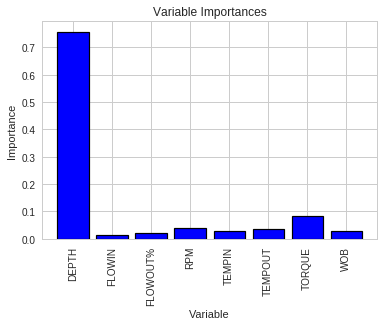

In [0]:
# list of x locations for plotting
X_testues = list(range(len(importances)))

# Make a bar chart
plt.bar(X_testues, importances, orientation = 'vertical', color = 'b', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(X_testues, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Now, we want to analyze how many features are required to achive the **95% of the importance retained**. Therefore, we are going to visualize the cumulative importance. The features are sorted according to the *importance value*.  

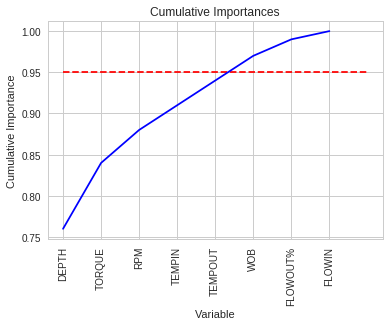

In [0]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(X_testues, cumulative_importances, 'b-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(X_testues, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

#### Limit number of features

In [0]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


In [0]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
important_indices
# # Create training and testing sets with only the important features
important_train_features = X_train[:, important_indices]
important_val_features = X_test[:, important_indices]

# # Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important val features shape:', important_val_features.shape)

Important train features shape: (4185, 6)
Important val features shape: (1794, 6)


### Training and testing in features selected 
Then, we evaluate on the **test data set** the performance using the important features.

In [0]:
# Train the expanded model on only the important features
rf.fit(important_train_features, y_train);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
# Make predictions on validation data
predictions_import = rf.predict(important_val_features)

# Metrics
print('Mean absolute error:',  round(mean_absolute_error(y_test, predictions_import),2))
print('Root mean squared error:',   round(sqrt(mean_squared_error(y_test, predictions_import)),2))
print('R2:',                   round(r2_score(y_test, predictions_import),2))
#print('Explained variance score:', explained_variance_score(y_test, predictions_import))

Mean absolute error: 26.88
Root mean squared error: 50.62
R2: 0.81


### Comparing performance and time


In [0]:
# We require to import the time library for the run time evaluation
import time

# All features training and testing time
all_features_time = []

# We decide to do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf.fit(X_train, y_train)
    all_features_predictions = rf.predict(X_test)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/loc

All features total training and testing time: 0.18 seconds.


In [0]:
# Time training and testing for reduced feature set
reduced_features_time = []

# We decide to do 10 iterations and take average for reduced features
for _ in range(10):
    start_time = time.time()
    rf.fit(important_train_features, y_train)
    reduced_features_predictions = rf.predict(important_val_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was pas

Reduced features total training and testing time: 0.15 seconds.


In [0]:
# Mean absolute error
all_mean_absolute_error=mean_absolute_error(y_test, predictions_rf)
reduced_mean_absolute_error=mean_absolute_error(y_test, predictions_import)

# Root squared mean error
all_root_mean_squared_error=sqrt(mean_squared_error(y_test, predictions_rf))
reduced_root_mean_squared_error=sqrt(mean_squared_error(y_test, predictions_import))

# R2 score
all_r2_score=r2_score(y_test, predictions_rf)
reduced_r2_score=r2_score(y_test, predictions_import)

# Summarize the data in a Dataframe
comparison = pd.DataFrame({'Features': ['all (8)', 'reduced (6)'], 
                           'R2': [round(all_r2_score, 2), round(reduced_r2_score, 2)],
                           'Mean absolute error': [round(all_mean_absolute_error, 2), round(reduced_mean_absolute_error, 2)],
                           'Root mean squared error': [round(all_root_mean_squared_error, 2), round(reduced_root_mean_squared_error, 2)],
                           'Run time': [round(all_features_time, 2), round(reduced_features_time, 2)]})

comparison[['Features','R2', 'Mean absolute error', 'Root mean squared error', 'Run time']]

,Features,R2,Mean absolute error,Root mean squared error,Run time
0,all (8),0.81,26.77,50.42,0.18
1,reduced (6),0.81,26.88,50.62,0.15


### Examine the default Random Forest to determine parameters


In [0]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Defining hyperparameters

In [0]:
# Definition of specific parameters for Random forest 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 30, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [4, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3, 4, 5, 10],
 'n_estimators': [2,
                  107,
                  212,
                  317,
                  422,
                  527,
                  632,
                  738,
                  843,
                  948,
                  1053,
                  1158,
                  1263,
                  1369,
                  1474,
                  1579,
                  1684,
                  1789,
                  1894,
                  2000]}


### Random search with cross validation
In cross validation, the training set is split into k smaller sets. We require to follow the following steps: 
* A model is trained using $k-1$of the folds as training data (Block of the data to train).
* The resulting model is validated on the remaining part of the data (Test data). Therefore, we can test the best parameters in this part od the data.
* The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. 
* The method is computationally expensive. 
![alt text](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [0]:

rf = RandomForestRegressor(random_state = 42)

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across different combinations.
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 15, scoring='neg_mean_absolute_error',  cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


### Definition of best hyperparameters

In [0]:
# Obtaining the best parameters
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1894}

### Evaluation of parameters in test set

In [0]:
best_random = rf_random.best_estimator_.fit(X_train, y_train)
predictions_best_random = best_random.predict(X_test)

print('Model score:', round(best_random.score(X_test, y_test),2))
print('Mean absolute error:', round(mean_absolute_error(y_test, predictions_best_random),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test, predictions_best_random)),2))
print('R2:', round(r2_score(y_test, predictions_best_random),2))

r2_rf=r2_score(y_test, predictions_best_random)
Mean_absolute_error_rf=mean_absolute_error(y_test, predictions_best_random)
Root_mean_squared_error_rf=sqrt(mean_squared_error(y_test, predictions_best_random))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Model score: 0.82
Mean absolute error: 25.6
Root mean squared error: 48.89
R2: 0.82


### Visualization of rate of penetration prediction with best hyperparameters

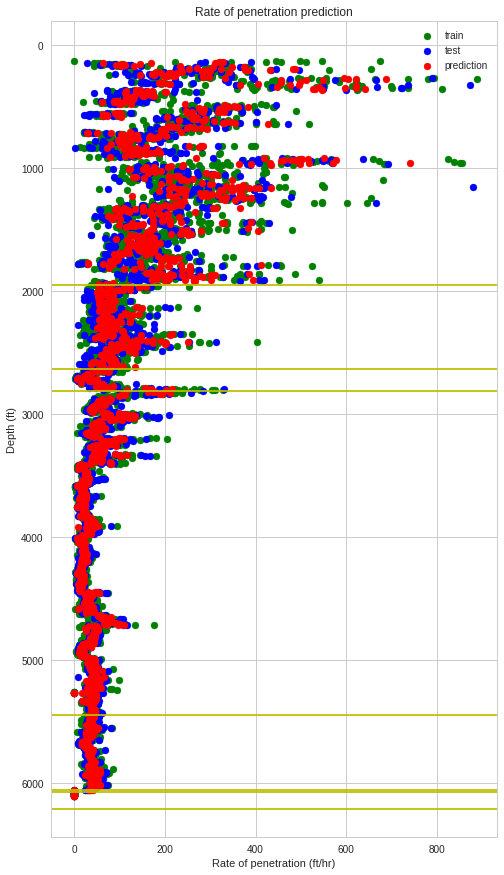

In [0]:
fig, ax=plt.subplots(figsize=(8,15))
ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="test")
ax.scatter(predictions_best_random , X_test[:,[0]], color='red', label="prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc="best")
depth = [1950, 2630, 2810, 5445, 6060, 6075, 6210, 6950, 6960, 7200, 7230, 7320, 7350, 7360, 7370, 7390, 7400, 7470, 7480, 7510, 7540, 8100]
for i in range(len(depth)):
  plt.axhline(depth[i], color='y')
plt.show()


## Prediction with Support vector machine

In [0]:
# fit a model
sv = SVR(kernel= 'rbf', degree=3, gamma='auto_deprecated', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_sv=sv.fit(X_train_scaled, y_train_scaled)
predictions_sv = sv.predict(X_test_scaled)

print('Model score:', round(sv.score(X_test_scaled, y_test_scaled),2))
print('Mean absolute error:', round(mean_absolute_error(y_test_scaled, predictions_sv),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test_scaled, predictions_sv)),2))
print('R2:', round(r2_score(y_test_scaled, predictions_sv),2))
#print('Explained variance score:', explained_variance_score(y_test, predictions_sv))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model score: 0.61
Mean absolute error: 0.34
Root mean squared error: 0.61
R2: 0.61


In [0]:
predictions_sv_rescale = scalery.inverse_transform(predictions_sv, copy=None)

print('Mean absolute error:', round(mean_absolute_error(y_test_scaled, predictions_sv_rescale ),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test_scaled, predictions_sv_rescale)),2))

Mean absolute error: 94.18
Root mean squared error: 126.82


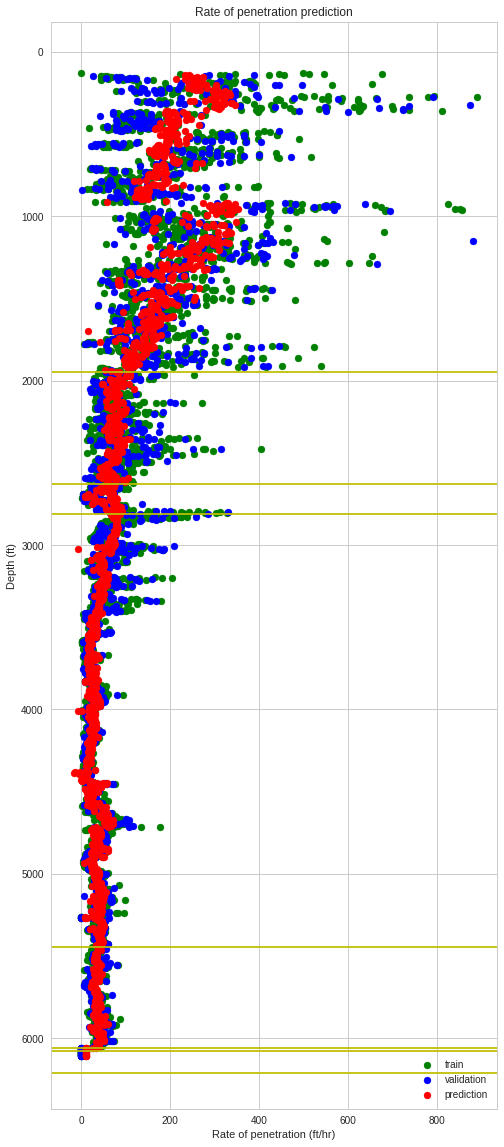

In [0]:
fig, ax=plt.subplots(figsize=(8,20))

ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="validation")
ax.scatter(predictions_sv_rescale  , X_test[:,[0]], color='red', label= "prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc='lower right')
depth = [1950, 2630, 2810, 5445, 6060, 6075, 6210, 6950, 6960, 7200, 7230, 7320, 7350, 7360, 7370, 7390, 7400, 7470, 7480, 7510, 7540, 8100]
for i in range(len(depth)):
  plt.axhline(depth[i], color='y')
plt.show()


### Examine the default Support vector to determine parameters

In [0]:
# Look at parameters used by our current support vector regressor
print('Parameters currently in use:\n')
pprint(sv.get_params())

Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


### Defining hyperparameters

In [0]:
# Kernel function 
kernel= [ 'linear' , 'poly', 'rbf', 'sigmoid']
# Epsilon: It specifies the epsilon-tube within which no penalty is associated in the training loss 
# function with points predicted within a distance epsilon from the actual value
epsilon=[ 0.01 , 0.1, 1, 10]
# Penalty parameter C of the error term
C= [ 1,  10]
# Kernel coefficient. Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
gamma= [0.0001, 0.001, 0.01, 0.1]
# coef0 : float, optional (default=0.0). Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’
coef0 = [3]

# Create the random grid
random_grid_sv = {'kernel': kernel,
                  'epsilon': epsilon,
                   'C': C,
                   'gamma': gamma,
                   'coef0': coef0}

pprint(random_grid_sv)

{'C': [1, 10],
 'coef0': [3],
 'epsilon': [0.01, 0.1, 1, 10],
 'gamma': [0.0001, 0.001, 0.01, 0.1],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}


### Random search with cross validation in support vector

In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
sv_cv_base = SVR(C=1)
# Random search of parameters, using 3 fold cross validation, 
# search across (100) different combinations, and use all available cores
sv_random = RandomizedSearchCV(estimator=sv_cv_base, param_distributions=random_grid_sv,
                              n_iter = 10, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
sv_random.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'epsilon': [0.01, 0.1, 1, 10], 'C': [1, 10], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'coef0': [3]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=2)

### Definition of best hyperparameters

In [0]:
sv_random.best_params_

{'C': 1, 'coef0': 3, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

### Evaluation of best parameters in test set

In [0]:
best_random_cv = sv_random.best_estimator_
best_random_cv.fit(X_train_scaled, y_train_scaled)
predictions_best_random_cv = best_random_cv.predict(X_test_scaled)

print('Model score:', round(best_random_cv.score(X_test_scaled, y_test_scaled),2))
print('Mean absolute error:', round(mean_absolute_error(y_test_scaled, predictions_best_random_cv),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test_scaled, predictions_best_random_cv)),2))
print('R2:', round(r2_score(y_test_scaled, predictions_best_random_cv),2))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model score: 0.52
Mean absolute error: 0.38
Root mean squared error: 0.68
R2: 0.52


In [0]:
predictions_sv_rescale_cv = scalery.inverse_transform(predictions_best_random_cv, copy=None)

In [0]:
print('Mean absolute error:', round(mean_absolute_error(y_test, predictions_sv_rescale_cv ),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test, predictions_sv_rescale_cv )),2))

r2_svm=r2_score(y_test_scaled, predictions_best_random_cv)
Mean_absolute_error_svm=mean_absolute_error(y_test, predictions_sv_rescale_cv )
Root_mean_squared_error_svm=sqrt(mean_squared_error(y_test, predictions_sv_rescale_cv ))


Mean absolute error: 44.82
Root mean squared error: 79.91


### Visualization of rate of penetration prediction  with best hyperparameters

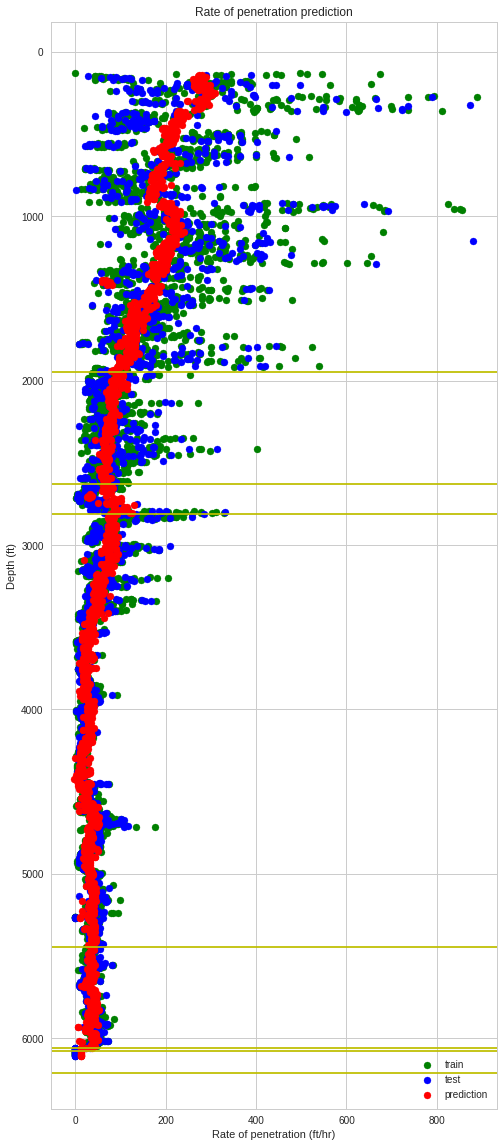

In [0]:
fig, ax=plt.subplots(figsize=(8,20))
#ax.plot(df1['ROP(1 ft)'], df1['Depth(m)'], color='blue')
ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="test")
ax.scatter(predictions_sv_rescale_cv , X_test[:,[0]], color='red', label="prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc='lower right')
depth = [1950, 2630, 2810, 5445, 6060, 6075, 6210, 6950, 6960, 7200, 7230, 7320, 7350, 7360, 7370, 7390, 7400, 7470, 7480, 7510, 7540, 8100]
for i in range(len(depth)):
  plt.axhline(depth[i], color='y')
plt.show()
#print(X_test.shape, y_test.shape)

## Prediction with Neural networks 

In [0]:
nn_regressor= MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                            power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False,  momentum=0.9, nesterovs_momentum=True, 
                           early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)                   

In [0]:
model_nn=nn_regressor.fit(X_train_scaled, y_train_scaled)
predictions_nn = nn_regressor.predict(X_test_scaled)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
print('Model score:', nn_regressor.score(X_test_scaled, y_test_scaled))
print('Mean absolute error:', mean_absolute_error(y_test_scaled, predictions_nn))
print('Root mean squared error:', sqrt(mean_squared_error(y_test_scaled, predictions_nn)))
print('R2:', r2_score(y_test_scaled, predictions_nn) )

Model score: 0.6270636314095118
Mean absolute error: 0.35963845131196137
Root mean squared error: 0.6014228554672559
R2: 0.6270636314095118


In [0]:
predictions_nn_rescale = scalery.inverse_transform(predictions_nn, copy=None)


In [0]:
print('Mean absolute error:', mean_absolute_error(y_test, predictions_nn_rescale ))
print('Root mean squared error:', sqrt(mean_squared_error(y_test, predictions_nn_rescale )))

Mean absolute error: 42.049181459995445
Root mean squared error: 70.31878457788852


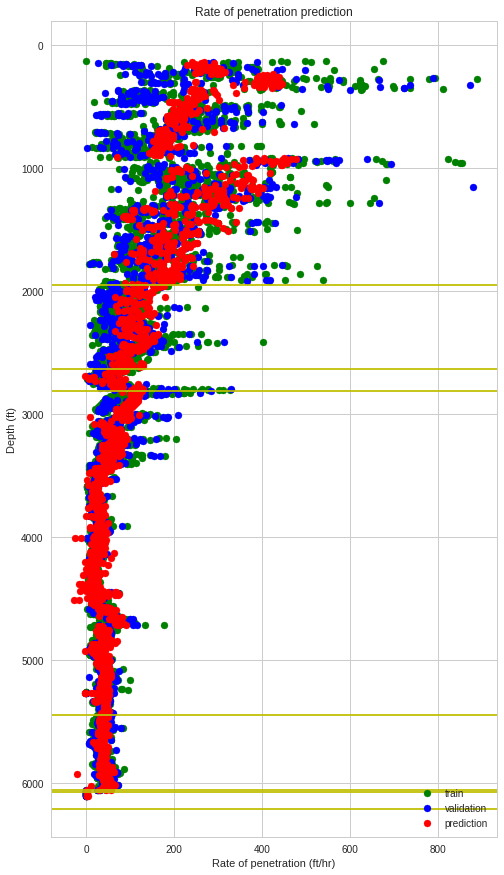

In [0]:

fig, ax=plt.subplots(figsize=(8,15))
ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="validation")
ax.scatter(predictions_nn_rescale  , X_test[:,[0]], color='red', label="prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc='lower right')
depth = [1950, 2630, 2810, 5445, 6060, 6075, 6210, 6950, 6960, 7200, 7230, 7320, 7350, 7360, 7370, 7390, 7400, 7470, 7480, 7510, 7540, 8100]
for i in range(len(depth)):
  plt.axhline(depth[i], color='y')
plt.show()


In [0]:
# Look at parameters used by our current support vector regressor
print('Parameters currently in use:\n')
pprint(nn_regressor.get_params())

Parameters currently in use:

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


In [0]:
# Solver 
solver = [ 'lbfgs', 'sgd', 'adam' ]
#Number of neurons in the hidden layer (s)
hidden_layer_sizes=[ 2, 3, 4, (2,1), (2,2), (3,1), (3,2), (3,3)]
# Activation function
activation=['identity', 'logistic', 'tanh', 'relu']
# L2 regularization 
alpha= [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ]


# Create the random grid
random_grid_nn = {'solver': solver,
                  'hidden_layer_sizes': hidden_layer_sizes,
                   'activation': activation,
                   'alpha': alpha}

pprint(random_grid_nn)

{'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
 'hidden_layer_sizes': [2, 3, 4, (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)],
 'solver': ['lbfgs', 'sgd', 'adam']}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
nn_cv_base = MLPRegressor(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across (100) different combinations, and use all available cores
nn_cv_random = RandomizedSearchCV(estimator=nn_cv_base, param_distributions=random_grid_nn,
                              n_iter = 10, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
nn_cv_random.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [2, 3, 4, (2, 1), (2, 2), (3, 1), (3, 2), (3, 3)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [0]:
nn_cv_random.best_params_

{'activation': 'relu',
 'alpha': 0.001,
 'hidden_layer_sizes': 4,
 'solver': 'lbfgs'}

### Evaluation of best parameters in test set

In [0]:
best_random_nn_cv = nn_cv_random.best_estimator_
best_random_nn_cv.fit(X_train_scaled, y_train_scaled)
predictions_best_random_nn_cv = best_random_nn_cv.predict(X_test_scaled)

print('Model score:', best_random_nn_cv.score(X_test_scaled, y_test_scaled))
print('Mean absolute error:', mean_absolute_error(y_test_scaled, predictions_best_random_nn_cv))
print('Root mean squared error:', sqrt(mean_squared_error(y_test_scaled, predictions_best_random_nn_cv)))
print('R2:', r2_score(y_test_scaled, predictions_best_random_nn_cv) )

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model score: 0.5998632110263222
Mean absolute error: 0.3824520616251288
Root mean squared error: 0.6229695233402176
R2: 0.5998632110263223


In [0]:
predictions_nn_rescale_cv = scalery.inverse_transform(predictions_best_random_nn_cv, copy=None)

In [0]:
print('Mean absolute error:', mean_absolute_error(y_test, predictions_nn_rescale_cv ))
print('Root mean squared error:', sqrt(mean_squared_error(y_test, predictions_nn_rescale_cv )))


r2_nn=r2_score(y_test_scaled, predictions_best_random_nn_cv)
Mean_absolute_error_nn=mean_absolute_error(y_test, predictions_nn_rescale_cv )
Root_mean_squared_error_nn=sqrt(mean_squared_error(y_test, predictions_nn_rescale_cv))

Mean absolute error: 44.71656487329984
Root mean squared error: 72.83803618722911


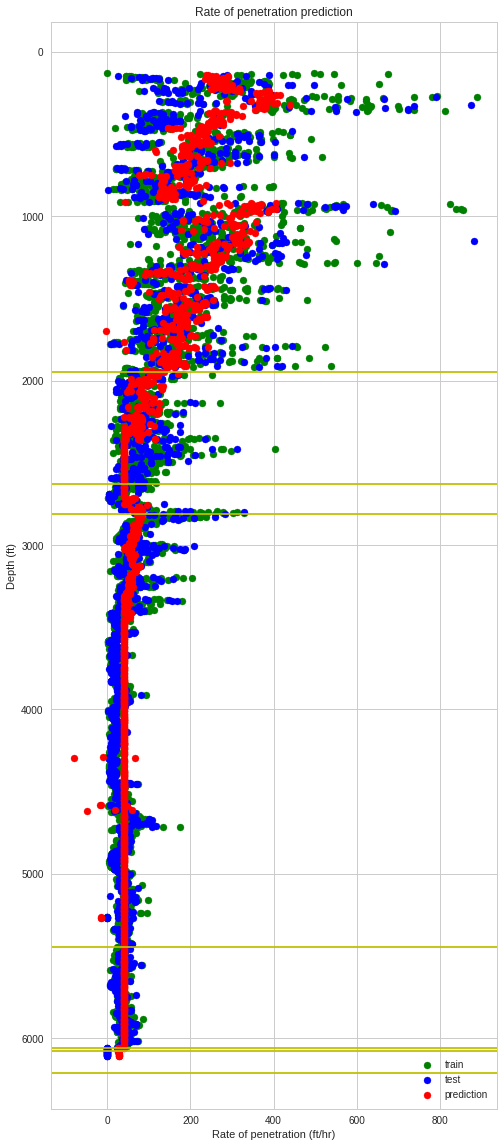

In [0]:
fig, ax=plt.subplots(figsize=(8,20))

ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="test")
ax.scatter(predictions_nn_rescale_cv  , X_test[:,[0]], color='red', label="prediction")

ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc='lower right')
depth = [1950, 2630, 2810, 5445, 6060, 6075, 6210, 6950, 6960, 7200, 7230, 7320, 7350, 7360, 7370, 7390, 7400, 7470, 7480, 7510, 7540, 8100]
for i in range(len(depth)):
  plt.axhline(depth[i], color='y')
plt.show()


## Prediction with Deep learning

In [0]:
model = tf.keras.Sequential()

In [0]:
model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=8)) #X,Y input dimensions. Connecting to 15 units with relu activation. 
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1)) #Prediction of rate of penetration, so one output

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                135       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 306
Trainable params: 306
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Use tf.cast instead.


In [0]:
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), nb_epoch=300, batch_size=3000, verbose=0)

Instructions for updating:
Use tf.cast instead.


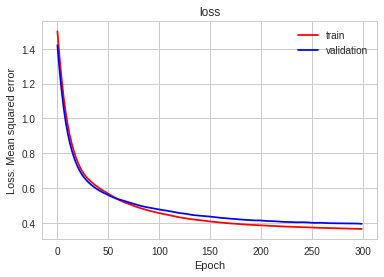

In [0]:
fig, ax=plt.subplots()
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")
plt.ylabel('Loss: Mean squared error'); plt.xlabel('Epoch');

### Evaluation in test set

In [0]:
predictions_deep_nn = model.predict(X_test_scaled)

print('Mean absolute error:', mean_absolute_error(y_test_scaled, predictions_deep_nn))
print('Root mean squared error:', sqrt(mean_squared_error(y_test_scaled, predictions_deep_nn)))
print('R2:', r2_score(y_test_scaled, predictions_deep_nn) )

Mean absolute error: 0.375717054001975
Root mean squared error: 0.627651028123387
R2: 0.5938267011753519


In [0]:
predictions_deepnn_rescale = scalery.inverse_transform(predictions_deep_nn, copy=None)
#predictions_deepnn_rescale 

In [0]:
print('Mean absolute error:', mean_absolute_error(y_test, predictions_deepnn_rescale ))
print('Root mean squared error:', sqrt(mean_squared_error(y_test, predictions_deepnn_rescale )))

r2_deepnn=r2_score(y_test_scaled, predictions_deep_nn)
Mean_absolute_error_deepnn=mean_absolute_error(y_test, predictions_deepnn_rescale  )
Root_mean_squared_error_deepnn=sqrt(mean_squared_error(y_test, predictions_deepnn_rescale  ))


Mean absolute error: 43.92910308958163
Root mean squared error: 73.3854007207499


### Evaluation in test set

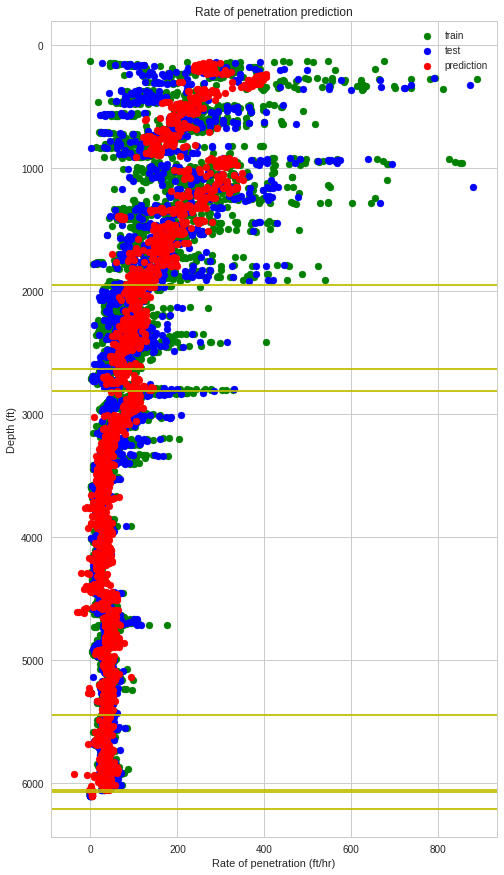

In [0]:
fig, ax=plt.subplots(figsize=(8,15))

ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="test")
ax.scatter(predictions_deepnn_rescale , X_test[:,[0]], color='red', label="prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.legend(loc="best")
plt.ylabel('Depth (ft)'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
depth = [1950, 2630, 2810, 5445, 6060, 6075, 6210, 6950, 6960, 7200, 7230, 7320, 7350, 7360, 7370, 7390, 7400, 7470, 7480, 7510, 7540, 8100]
for i in range(len(depth)):
  plt.axhline(depth[i], color='y')
plt.show()


## XGBoost

In [0]:
!pip install xgboost

In [0]:
from xgboost import XGBClassifier
import xgboost

In [0]:
# Random analysis to fit Random forest 
xgb = xgboost.XGBRegressor().fit(X_train, y_train) #Random_state is the seed used by the random number generator
predictions_xgb = xgb.predict(X_test)

# Metrics
print('Model score:',              round(xgb.score(X_test, y_test),2))
print('Mean absolute error:',      round(mean_absolute_error(y_test, predictions_xgb),2))
print('Root mean squared error:',  round(sqrt(mean_squared_error(y_test, predictions_xgb)),2))
print('R2:',                       round(r2_score(y_test, predictions_xgb),2))

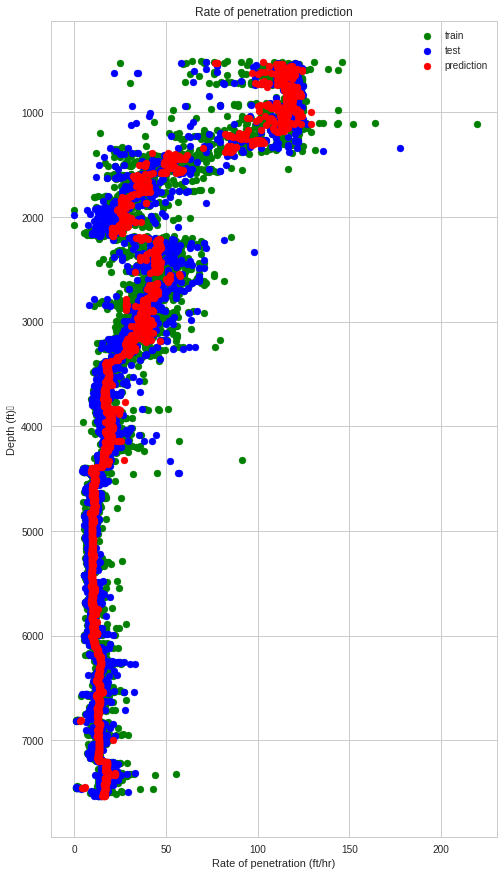

In [0]:
fig, ax=plt.subplots(figsize=(8,15))
#ax.plot(df1['ROP(1 ft)'], df1['Depth(ft)'], color='blue')
ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="test")
ax.scatter(predictions_xgb , X_test[:,[0]], color='red', label="prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)	'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc="best")
plt.show()

### Examine the default Random Forest to determine parameters

In [0]:
# Look at parameters used by our current support vector regressor
print('Parameters currently in use:\n')
pprint(xgb.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


### Defining hyperparameters

In [0]:
# Definition of specific parameters for XGBoost

# Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 2000, num = 20)]
# Maximum depth of a tree
max_depth = [3,4,5,6,7,8,9,10]

# Learning rate Step size shrinkage used in update to prevents overfitting
learning_rate = [ 0.0001, 0.001, 0.01, 0.1]
# Minimum sum of instance weight (hessian) needed in a child
min_child_weight  = [2,4,6,8,10,12]
# Minimum loss reduction required to make a further partition on a leaf node of the tree
gamma = [i/10.0 for i in range(0,5)]
# Subsample ratio of the training instances. 
subsample=[0.7,0.8,0.9]

# Create the random grid
xgb_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'min_child_weight': min_child_weight,
               'gamma': gamma,
               'subsample': subsample}

pprint(xgb_grid)

{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
 'min_child_weight': [2, 4, 6, 8, 10, 12],
 'n_estimators': [2,
                  107,
                  212,
                  317,
                  422,
                  527,
                  632,
                  738,
                  843,
                  948,
                  1053,
                  1158,
                  1263,
                  1369,
                  1474,
                  1579,
                  1684,
                  1789,
                  1894,
                  2000],
 'subsample': [0.7, 0.8, 0.9]}


### Random search with cross validation in XGBoost

In [0]:
xgb_p = xgboost.XGBRegressor()

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across different combinations.
xgb_random = RandomizedSearchCV(estimator=xgb_p, param_distributions=xgb_grid, n_iter = 20, scoring='neg_mean_absolute_error',  cv = 4, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

# Fit the random search model
xgb_random.fit(X_train, y_train);

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.3min finished


[15:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Definition of best hyperparameters

In [0]:
xgb_random.best_params_

{'gamma': 0.4,
 'learning_rate': 0.01,
 'max_depth': 9,
 'min_child_weight': 12,
 'n_estimators': 1474,
 'subsample': 0.8}

### Evaluation of best best parameters in test set

In [0]:
best_random_xgb = xgb_random.best_estimator_.fit(X_train, y_train)
predictions_best_random_xgb = best_random_xgb.predict(X_test)

print('Model score:', round(best_random_xgb.score(X_test, y_test),2))
print('Mean absolute error:', round(mean_absolute_error(y_test, predictions_best_random_xgb),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test, predictions_best_random_xgb)),2))
print('R2:', round(r2_score(y_test, predictions_best_random_xgb),2))

r2_xgb=r2_score(y_test, predictions_best_random_xgb)
Mean_absolute_error_xgb=mean_absolute_error(y_test, predictions_best_random_xgb)
Root_mean_squared_error_xgb=sqrt(mean_squared_error(y_test, predictions_best_random_xgb))

[15:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model score: 0.92
Mean absolute error: 4.9
Root mean squared error: 9.8
R2: 0.92


### Visualization of rate of penetration prediction with best hyperparameters

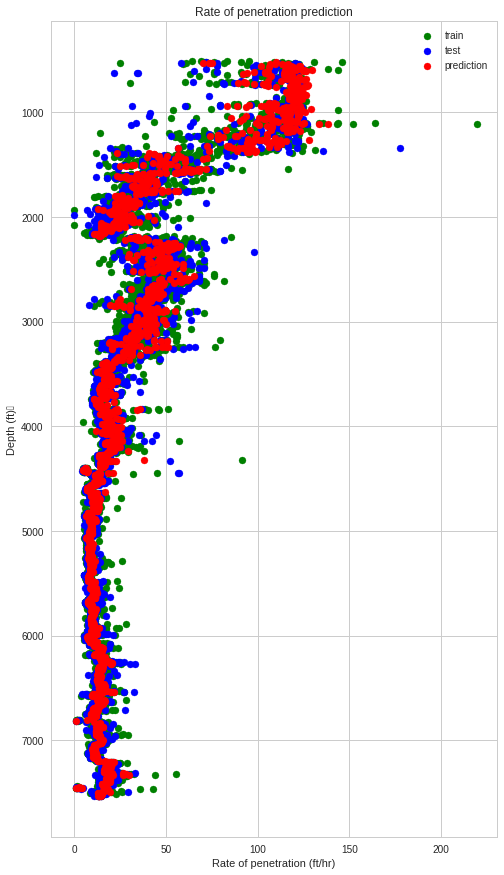

In [0]:
fig, ax=plt.subplots(figsize=(8,15))
#ax.plot(df1['ROP(1 ft)'], df1['Depth(ft)'], color='blue')
ax.scatter(y_train, X_train[:,[0]], color='green', label="train")
ax.scatter(y_test, X_test[:,[0]], color='blue', label="test")
ax.scatter(predictions_best_random_xgb , X_test[:,[0]], color='red', label="prediction")
ay = plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)	'); plt.xlabel('Rate of penetration (ft/hr)'); plt.title('Rate of penetration prediction');
plt.legend(loc="best")
plt.show()


In [0]:
#Selecting ROP test set
y_predict_vis_xgb = pd.DataFrame(predictions_best_random_xgb)
# Merging the dataset
df_out_predict_xgb = X_test_vis.merge(y_predict_vis_xgb, how = 'right', left_index = True, right_index = True)
df_out_predict_xgb.columns = ['X_test_data', 'y_predict_xgb']
# df_out_predict_rf


In [0]:
#Visualization
output_notebook()
#Requirement of Bokeh to display the data
source1 = ColumnDataSource(df_out_train)
source2 = ColumnDataSource(df_out_test)
source3 = ColumnDataSource(df_out_predict_xgb)
# Check data

tools = [PanTool(), WheelZoomTool(), ResetTool(), 'box_select', 'lasso_select', 'save']
# Create scatter plot
p_rf = figure(x_axis_label='ROP (ft/h)', y_axis_label='Depth(ft)', tools=tools, plot_height=800, plot_width=400, title="Rate of penetration XGBoost")
p_rf.circle(x= 'y_train_data', y= 'X_train_data', color='deepskyblue', size=3, alpha=0.6, source=source1, legend='Train', muted_alpha=0.1)
p_rf.circle(x= 'y_test_data', y= 'X_test_data', color='green', size=3, alpha=0.6, source=source2, legend='Test', muted_alpha=0.1)
p_rf.circle(x= 'y_predict_xgb', y= 'X_test_data', color='darkviolet', size=3, alpha=0.6, source=source3, legend='Predict', muted_alpha=0.1)

p_rf.legend.click_policy = 'mute'

# Invert the data
xmax = df_out_train['y_train_data'].max()
xmin = df_out_train['y_train_data'].min()
ymax = df_out_train['X_train_data'].min()
ymin = df_out_train['X_train_data'].max()
p_rf.x_range = Range1d(xmin, xmax)
p_rf.y_range = Range1d(ymin, ymax)

show(p_rf) 

Loading BokehJS ...

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "x" value "y_predict_rf" (closest match: "y_predict_xgb") [renderer: GlyphRenderer(id='3728', ...)]


## Comparison of models

In [0]:
comparison_errors = pd.DataFrame({'Method': ['Random Forest', 'XGBoost', 'Support vector machine', 'Neural Network', 'Deep Neural Network'], 
                           'R2': [round(r2_rf, 2), round(r2_xgb, 2) , round(r2_svm, 2), round(r2_nn, 2), round(r2_deepnn, 2) ],
                           'Mean absolute error': [round(Mean_absolute_error_rf, 2), round(Mean_absolute_error_xgb, 2),round(Mean_absolute_error_svm, 2), round(Mean_absolute_error_nn, 2), round(Mean_absolute_error_deepnn, 2)],
                           'Root mean squared error': [round(Root_mean_squared_error_rf, 2), round(Root_mean_squared_error_xgb, 2), round(Root_mean_squared_error_svm, 2), round(Root_mean_squared_error_nn, 2), round(Root_mean_squared_error_deepnn, 2)]
                           })
comparison_errors[['Method','R2', 'Mean absolute error', 'Root mean squared error']]


,Method,R2,Mean absolute error,Root mean squared error
0,Random Forest,0.82,25.60,48.89
1,Support vector machine,0.52,44.82,79.91
2,Neural Network,0.60,44.72,72.84
3,Deep Neural Network,0.59,43.93,73.39


## Recurrent neural network with long short-term memory

In [0]:
from sklearn.preprocessing import StandardScaler
scalerdata = StandardScaler().fit(dfnew)
df_scaled = scalerdata.transform(dfnew)
df_scaled.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


(5979, 9)

In [0]:
train_size=int(len(df_scaled)*0.8)
test_size=len(df_scaled)-train_size

In [0]:
train_x=df_scaled[0:train_size,1:]
train_y=df_scaled[0:train_size,0]
test_x=df_scaled[train_size:len(df_scaled),1:]
test_y=df_scaled[train_size:len(df_scaled),0]
print(len(train_x),len(train_y),len(test_y),len(test_y))


print("x_train", train_x.shape)
print("y_train", train_y.shape)
print("x_test", test_x .shape)
print("y_test", test_y.shape)

4783 4783 1196 1196
x_train (4783, 8)
y_train (4783,)
x_test (1196, 8)
y_test (1196,)


In [0]:
unroll_length=50

def unroll(dfnew,sequence_length=24):
    result = []
    for index in range(len(dfnew) - sequence_length):
        result.append(dfnew[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
train_x = unroll(train_x,unroll_length)
test_x  = unroll(test_x,unroll_length)
train_y = train_y[-train_x.shape[0]:]
test_y  = test_y[-test_x.shape[0]:]

print("x_train", train_x.shape)
print("y_train", train_y.shape)
print("x_test", test_x .shape)
print("y_test", test_y.shape)

x_train (4733, 50, 8)
y_train (4733,)
x_test (1146, 50, 8)
y_test (1146,)


In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [0]:
# Build the model
model_rnn = Sequential()

model_rnn.add(LSTM(input_dim=train_x.shape[-1], output_dim=200, return_sequences=True))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(200, return_sequences=False))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=1))
model_rnn.add(Activation('linear'))




# model_rnn.add(tf.keras.layers.Dense(15, activation='relu', input_dim=8)) #X,Y input dimensions. Connecting to 15 units with relu activation. 
# model_rnn.add(tf.keras.layers.Dense(10, activation='relu'))
# model_rnn.add(tf.keras.layers.Dense(1)) #Prediction of rate of penetration, so one output

start = time.time()
model_rnn.compile(loss='mse', optimizer='rmsprop') # 'adam'
print('compilation time : {}'.format(time.time() - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 8), units=200)`
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
compilation time : 0.03192281723022461


In [0]:
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 200)         167200    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 488,201
Trainable params: 488,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_rnn.fit(train_x, train_y, validation_data=(test_x, test_y), nb_epoch=100, batch_size=3000, verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


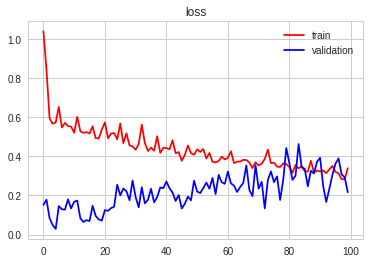

In [0]:
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

In [0]:
predictions_rnn = model_rnn.predict(test_x)

print('Mean absolute error:', mean_absolute_error(test_y, predictions_rnn))
print('Root mean squared error:', sqrt(mean_squared_error(test_y, predictions_rnn)))
print('R2:', r2_score(test_y, predictions_rnn) )

Mean absolute error: 0.411789770257546
Root mean squared error: 0.46525987111856415
R2: -12.447050828131827
